In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [33]:
dir = 'C:/Users/fitzpatrick/Desktop/Data/Input/'
lake = ['MiHur','Erie','Ont','Sup']

In [34]:
# Step 1: Read in the historical data
# P, E, R are read in from a csv I created for easy use
data_1 = pd.read_csv(dir+lake[1]+'_dataset_6mo_cms.csv',sep=',')
data_1['Date'] = pd.to_datetime(data_1['Date'])
data_1['Month'] = data_1['Date'].dt.month

# NBS from L2SWBM for each lake
data_2 = pd.read_csv(dir+lake[1]+'_l2swbm_nbs.csv',sep=',')
data_2['Date'] = pd.to_datetime(data_2['Date'])
data_2.set_index('Date', inplace=True)

# Merge them into one dataframe to align the timeframes
df = data_1.merge(data_2, on='Date')
df.head()

,Date,R(m),P(m),E(m),R(m-1),P(m-1),E(m-1),R(m-2),P(m-2),E(m-2),...,P(m-5),E(m-5),R(m-6),P(m-6),E(m-6),Month,NBS(m),NBS(m-1),NBS(m-2),NBS(m-3)
0,1979-07-01,270.147413,838.679304,447.521306,325.820659,799.979063,289.695399,524.612246,1229.248943,199.110481,...,688.470282,396.122241,0.000000,1054.201890,456.765696,7,48.9967,79.0767,152.4003,278.7354
1,1979-08-01,273.041284,862.776304,581.730925,270.147413,838.679304,447.521306,325.820659,799.979063,289.695399,...,1088.281147,82.955132,369.239992,688.470282,396.122241,8,29.2268,48.9967,79.0767,152.4003
2,1979-09-01,485.873656,651.082724,562.513794,273.041284,862.776304,581.730925,270.147413,838.679304,447.521306,...,1655.896637,145.850495,652.335147,1088.281147,82.955132,9,-13.9793,29.2268,48.9967,79.0767
3,1979-10-01,338.298057,752.020394,609.128485,485.873656,651.082724,562.513794,273.041284,862.776304,581.730925,...,1229.248943,199.110481,1275.329971,1655.896637,145.850495,10,-61.0342,-13.9793,29.2268,48.9967
4,1979-11-01,485.438656,1342.701253,405.993138,338.298057,752.020394,609.128485,485.873656,651.082724,562.513794,...,799.979063,289.695399,524.612246,1229.248943,199.110481,11,41.2668,-61.0342,-13.9793,29.2268


In [35]:
# Step 3: Prepate the data
# Extract features (precipitation, evaporation, runoff, water levels, and month) and target (net basin supply) from historical data
features = df[['P(m)', 'E(m)', 'R(m)', 'Date',]] #'Previous_Month_Water_Levels']]
features['Month'] = pd.to_datetime(features['Date']).dt.month  # Extract month from date
features = features.drop(columns=['Date'])

target = df['NBS(m)']

print(features, target)

            P(m)         E(m)        R(m)  Month
0     838.679304   447.521306  270.147413      7
1     862.776304   581.730925  273.041284      8
2     651.082724   562.513794  485.873656      9
3     752.020394   609.128485  338.298057     10
4    1342.701253   405.993138  485.438656     11
..           ...          ...         ...    ...
493   551.097063   831.246566  189.059673      8
494   395.970038  1060.993510  294.486327      9
495   898.734697  1028.411584  280.563542     10
496   925.980868   797.486195  388.672991     11
497   961.216488   604.988748  636.809018     12

[498 rows x 4 columns] 0      48.9967
1      29.2268
2     -13.9793
3     -61.0342
4      41.2668
        ...   
493   -39.4783
494   -92.2995
495   -36.1725
496   -45.7464
497    30.5666
Name: NBS(m), Length: 498, dtype: float64


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_8392\1183920742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Month'] = pd.to_datetime(features['Date']).dt.month  # Extract month from date


In [36]:
# Encoding categorical variables
features = pd.get_dummies(features, columns=['Month'])

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [37]:
# Gaussian Process Regression
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Fit the model
gpr.fit(X_train, y_train)

c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, random_state=42)

In [38]:
# Predictions
y_pred, sigma = gpr.predict(X_test, return_std=True)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(r_squared)

-0.035361853585042624


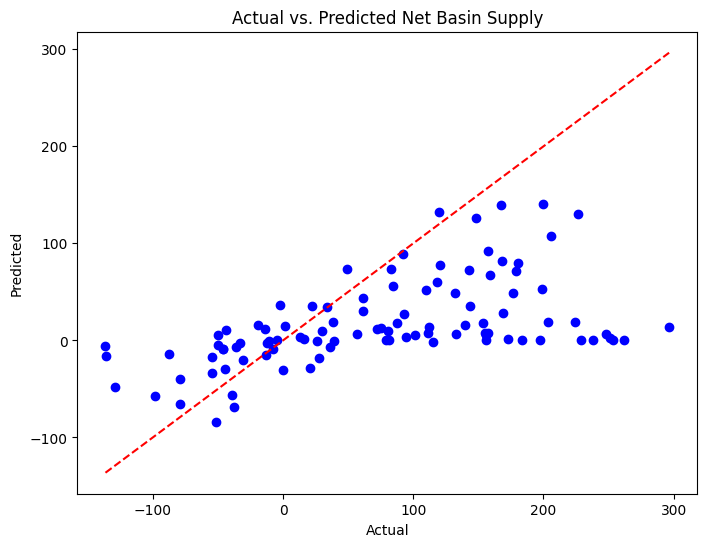

In [39]:
import matplotlib.pyplot as plt

# Step 10: Plot predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Net Basin Supply')
plt.show()